# import library yang diperlukan

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


# membaca dataset

In [2]:
df = pd.read_csv("Australian Vehicle Prices.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

# mengecek data sebelum di clean

In [3]:
print("=== DATA SEBELUM CLEANING (Raw Data) ===")
print(f"Total Baris: {len(df)}")

=== DATA SEBELUM CLEANING (Raw Data) ===
Total Baris: 16734


# Melihat Statistik Deskriptif Data

In [4]:
df.describe()

,Year
count,16733.000000
mean,2016.229248
std,5.247705
min,1940.000000
25%,2013.000000
50%,2017.000000
75%,2020.000000
max,2023.000000


# Data Cleaning: Membersihkan Kolom Price

In [5]:
df['Price'] = df['Price'].astype(str).str.replace('[^0-9]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Membuat Kategori Harga

In [6]:
bins = [0, 20000, 40000, 60000, np.inf]
labels = ['Murah', 'Sedang', 'Mahal', 'Sangat Mahal']
df['Price_Category'] = pd.cut(df['Price'], bins=bins, labels=labels)

# Data Cleaning: Membersihkan Kolom Numerik Lainnya

In [7]:
df['Kilometres'] = df['Kilometres'].astype(str).str.replace('[^0-9]', '', regex=True)
df['Kilometres'] = pd.to_numeric(df['Kilometres'], errors='coerce')

df['FuelConsumption'] = df['FuelConsumption'].astype(str).str.extract('(\d+\.?\d*)')
df['FuelConsumption'] = pd.to_numeric(df['FuelConsumption'], errors='coerce')

df['EngineSize'] = df['Engine'].astype(str).str.extract('(\d+\.\d+)')
df['EngineSize'] = pd.to_numeric(df['EngineSize'], errors='coerce')

df['Cylinders'] = df['CylindersinEngine'].astype(str).str.extract('(\d+)')
df['Cylinders'] = pd.to_numeric(df['Cylinders'], errors='coerce')

# Menghapus Data Kosong (Missing Values)

In [8]:
df = df.dropna()

print("\n=== DATA SETELAH CLEANING (Clean Data) ===")
print(f"Total Baris Tersisa: {len(df)}")


=== DATA SETELAH CLEANING (Clean Data) ===
Total Baris Tersisa: 8829


# Preprocessing: Label Encoding untuk Data Kategorikal

In [9]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Pemisahan Fitur (X) & Target (y) serta Standarisasi Data

In [10]:
X = df.drop(['Price', 'Price_Category'], axis=1)
y = df['Price_Category']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Membangun Model dengan Hyperparameter Tuning (GridSearch)

In [13]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,  
    cv=3,                   
    n_jobs=-1,              
    verbose=2               
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


# Menampilkan Parameter Terbaik

In [14]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.8492134272061649


# Prediksi dan Evaluasi Akurasi Model

In [15]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [16]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))

Test Accuracy: 0.8663646659116648


In [17]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Classification Report:
               precision    recall  f1-score   support

       Mahal       0.82      0.77      0.79       294
       Murah       0.90      0.91      0.90       584
Sangat Mahal       0.89      0.83      0.86       145
      Sedang       0.85      0.88      0.87       743

    accuracy                           0.87      1766
   macro avg       0.87      0.85      0.86      1766
weighted avg       0.87      0.87      0.87      1766



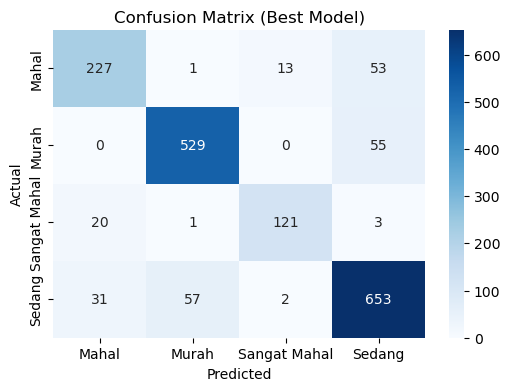

In [18]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Best Model)")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12624\360332389.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


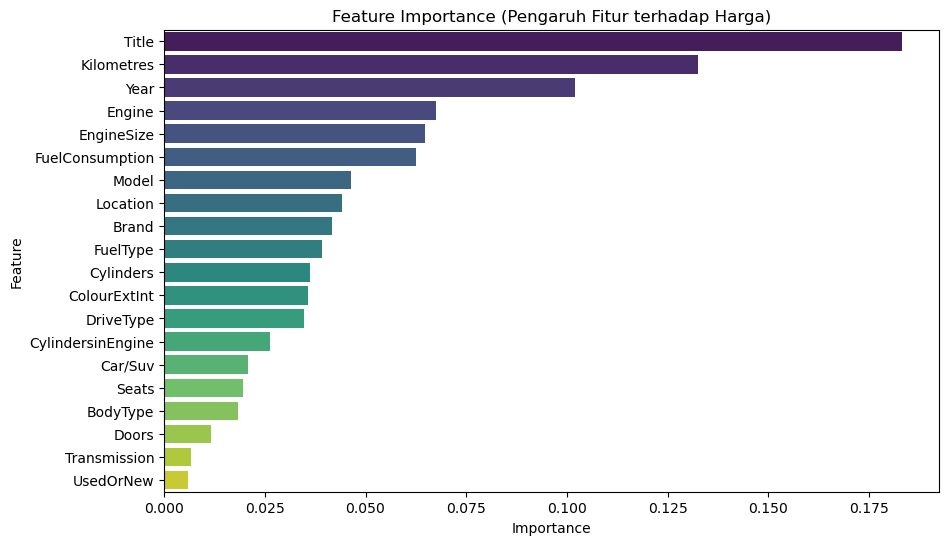

In [19]:
importances = best_model.feature_importances_
feature_names = X.columns # Pastikan X adalah DataFrame (bukan numpy array) saat split

feature_names = df.drop(['Price', 'Price_Category'], axis=1).columns

feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance (Pengaruh Fitur terhadap Harga)')
plt.show()

# Melihat hubungan antara Tahun (Year) atau Kilometer (Kilometres) dengan Harga (Price).

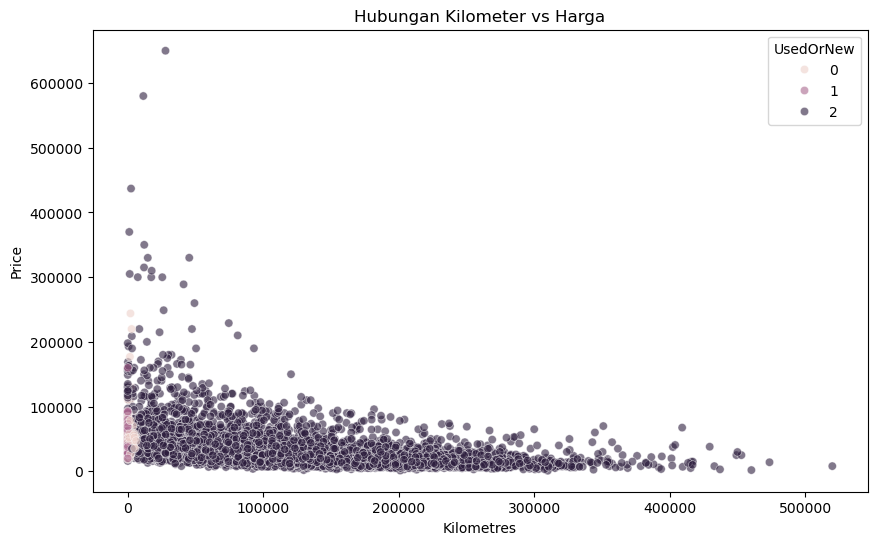

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Kilometres', y='Price', data=df, hue='UsedOrNew', alpha=0.6)
plt.title('Hubungan Kilometer vs Harga')
plt.show()

# Melihat tren rata-rata harga mobil dari tahun ke tahun.|

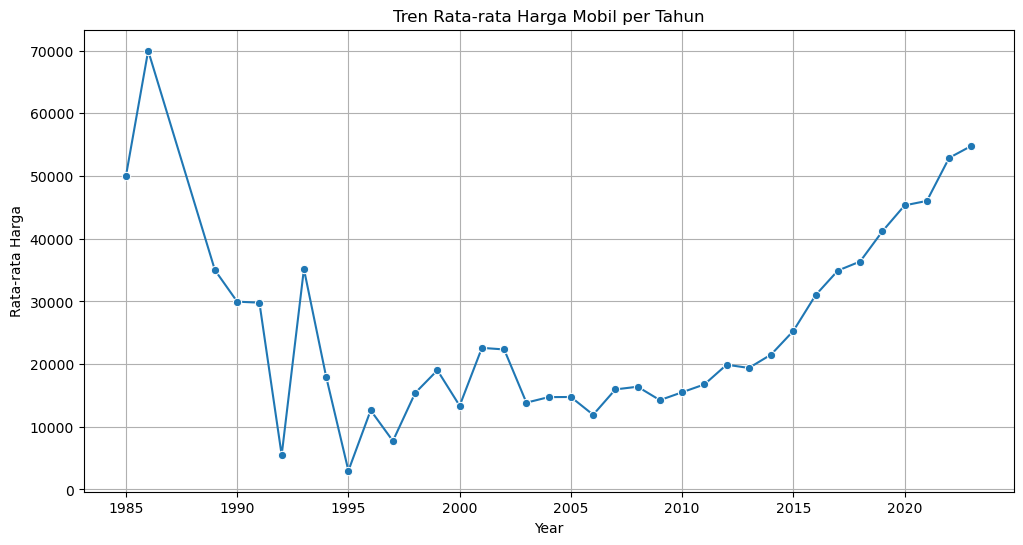

In [21]:
# Hitung rata-rata harga per tahun
price_trend = df.groupby('Year')['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Price', data=price_trend, marker='o')
plt.title('Tren Rata-rata Harga Mobil per Tahun')
plt.ylabel('Rata-rata Harga')
plt.grid(True)
plt.show()

# Melihat variabel mana yang paling berkorelasi dengan Harga.

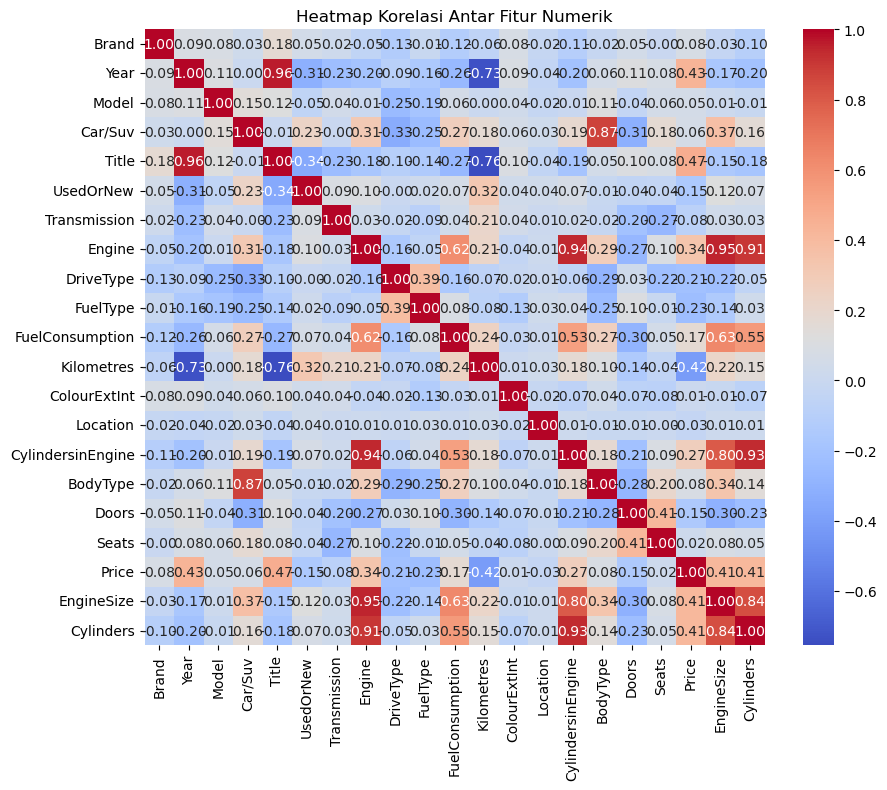

In [22]:
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()

# Visualisasi Distribusi Harga Kendaraan

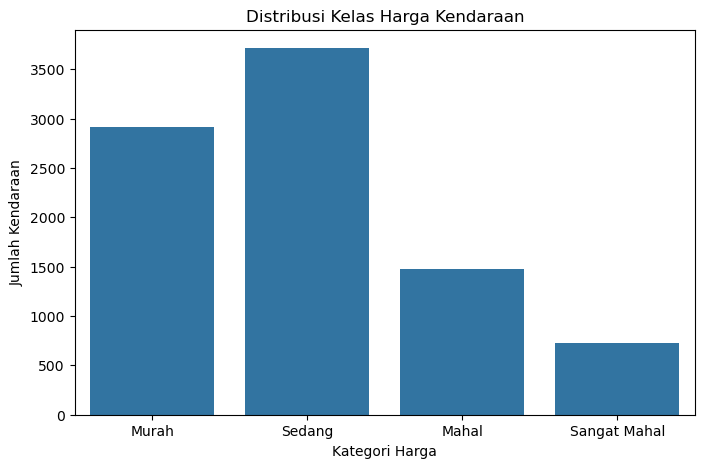

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Price_Category', data=df, order=['Murah', 'Sedang', 'Mahal', 'Sangat Mahal'])
plt.title('Distribusi Kelas Harga Kendaraan')
plt.xlabel('Kategori Harga')
plt.ylabel('Jumlah Kendaraan')
plt.show()

# Visualisasi Jumlah Kendaraan per Kategori Harga

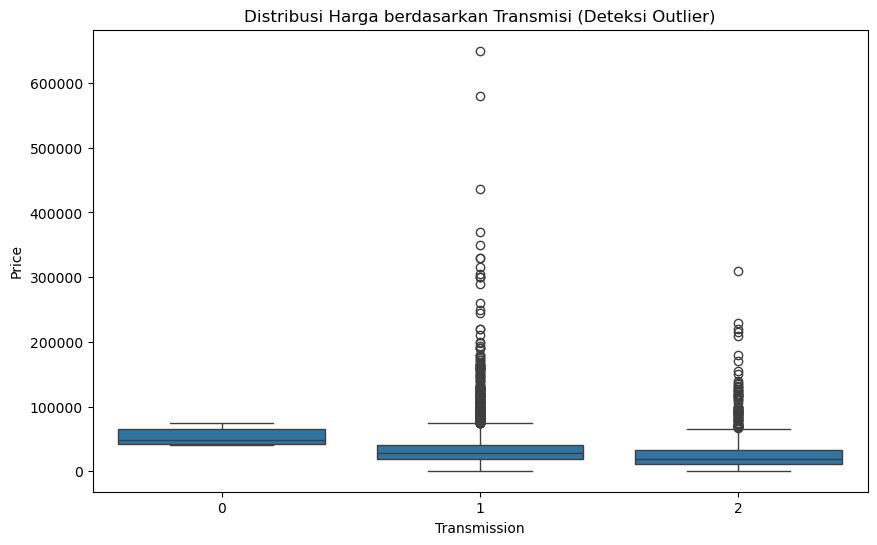

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Transmission', y='Price', data=df)
plt.title('Distribusi Harga berdasarkan Transmisi (Deteksi Outlier)')
plt.show()

# Visualisasi Distribusi Harga Kendaraan

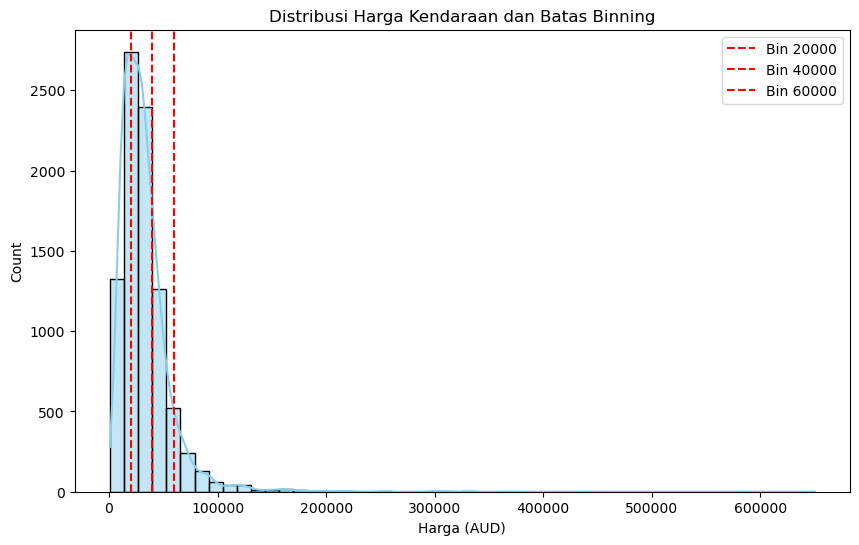

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True, color='skyblue')
for bin_val in [20000, 40000, 60000]:
    plt.axvline(bin_val, color='red', linestyle='--', label=f'Bin {bin_val}')
plt.title('Distribusi Harga Kendaraan dan Batas Binning')
plt.xlabel('Harga (AUD)')
plt.legend()
plt.show()

In [30]:
if 'X' in locals() and isinstance(X, pd.DataFrame):
    feature_names = X.columns.tolist()
else:
    # Fallback jika X sudah jadi array, kita ambil dari df asli dikurangi target
    # Pastikan 'df' adalah dataframe terakhir sebelum di-split
    feature_names = df.drop(['Price', 'Price_Category'], axis=1).columns.tolist()

# 2. Simpan Model dan komponen pendukung
try:
    model_data = {
        'model': best_model,              # Model terbaik dari GridSearch
        'encoders': label_encoders,       # Dictionary LabelEncoders
        'scaler': scaler,                 # Scaler untuk normalisasi
        'feature_names': feature_names    # Nama kolom urut
    }

    # Simpan ke file
    joblib.dump(model_data, 'car_price_prediction_model.pkl')
    print("✅ SUKSES! Model berhasil disimpan sebagai 'car_price_prediction_model.pkl'")
    print(f"Jumlah fitur yang disimpan: {len(feature_names)}")

except NameError as e:
    print("❌ ERROR: Variabel tidak ditemukan. Pastikan Anda sudah menjalankan semua sel di atas (Run All).")
    print(f"Detail: {e}")
except Exception as e:
    print(f"❌ ERROR Lainnya: {e}")

✅ SUKSES! Model berhasil disimpan sebagai 'car_price_prediction_model.pkl'
Jumlah fitur yang disimpan: 20
